# Analysing the Semantic Change of Synonymous Pairs

In [95]:
import pickle
from tqdm import tqdm
import os

import scipy.sparse as sp
import scipy.stats as stats
import numpy as np
import pandas as pd

from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import normalize
from scipy.stats import describe

import matplotlib.pyplot as plt

In [96]:
pos = 'A'
MATRIX_FOLDER = '/home/bastien/lscd/cooc_matrices_GNgrams_V2/'
SEMCHANGE_FOLDER = './semantic_change_measures/'
NEIGHBORS_FOLDER = './nearest_neighbors/'

DECADES = list(range(1890,2000,10))

In [97]:
with open(f'./words/fernald_syn_pairs_{pos}.pickle','rb') as f:
    syn_pairs = pickle.load(f)

In [98]:
if pos.lower() in ['a','adj','adjective']:
    pos = 'A'
    with open('./words/adjs_list.pickle','rb') as f:
        word_list = pickle.load(f)
elif pos.lower() in ['n','noun']:
    pos = 'N'
    with open('./words/nouns_list.pickle','rb') as f:
        word_list = pickle.load(f)
elif pos.lower() in ['v','verb']:
    pos = 'V'
    with open('./words/verbs_list.pickle','rb') as f:
        word_list = pickle.load(f)
else:
    raise ValueError('Invalid POS tag value : ' + pos)

word2ind = {word : i for i,word in enumerate(word_list)}
with open('./words/fernald_synonyms.pickle','rb') as f:
    syns_dict = pickle.load(f)[pos]
semchanges = pd.read_csv(SEMCHANGE_FOLDER+pos+'.csv',sep='\t',index_col='words')
neighbors_matrix = np.load(NEIGHBORS_FOLDER+'1890_'+pos+'.npy')

In [99]:
def JSD(arr1,arr2,base=None):
    '''
    Jensen-Shannon Divergence between two probability distributions. Square of the JS distance.
    '''
    return jensenshannon(arr1,arr2,base=base)**2

## Computing divergence in synonyms pairs

In [115]:
L_mat = sp.load_npz(MATRIX_FOLDER+f'cooc-matrix_1890_{pos}_L.npz')
R_mat = sp.load_npz(MATRIX_FOLDER+f'cooc-matrix_1890_{pos}_R.npz')
matrix_1890 = normalize(normalize(sp.hstack([L_mat,R_mat]), axis=0,norm='l1'), axis=1,norm='l1').toarray()

L_mat = sp.load_npz(MATRIX_FOLDER+f'cooc-matrix_1990_{pos}_L.npz')
R_mat = sp.load_npz(MATRIX_FOLDER+f'cooc-matrix_1990_{pos}_R.npz')
matrix_1990 = normalize(normalize(sp.hstack([L_mat,R_mat]), axis=0,norm='l1'), axis=1,norm='l1').toarray()

distances_1890 = []
distances_1990 = []
base = np.e
for i,(s1,s2) in tqdm(enumerate(syn_pairs), desc="Synonyms", total=len(syn_pairs)):
    ind1 = word2ind[s1]
    ind2 = word2ind[s2]
    v10, v20 = matrix_1890[[ind1,ind2]]
    distances_1890.append(JSD( v10 , v20 , base=base))
    v11, v21 = matrix_1990[[ind1,ind2]]
    distances_1990.append(JSD( v11 , v21 , base=base))
distances_1890 = np.array(distances_1890)
distances_1990 = np.array(distances_1990)
describe(distances_1890)

Synonyms: 100%|██████████| 271/271 [00:00<00:00, 1421.32it/s]


DescribeResult(nobs=271, minmax=(0.22816504352675643, 0.687709674183064), mean=0.5621737859752376, variance=0.007189736107093496, skewness=-0.9225696085158775, kurtosis=0.666318732320629)

In [101]:
describe(distances_1990)

DescribeResult(nobs=271, minmax=(0.3372462028222972, 0.9904422432618133), mean=0.8035829829425035, variance=0.01665628019412349, skewness=-1.0706399905547586, kurtosis=0.8276575059956772)

In [102]:
describe(distances_1990-distances_1890)

DescribeResult(nobs=271, minmax=(-0.43645907548023166, 0.2901548908843883), mean=-0.00746235020174513, variance=0.011677843389681211, skewness=-0.38069349357626786, kurtosis=1.5290289829524077)

## Analysing the divergence between pairs

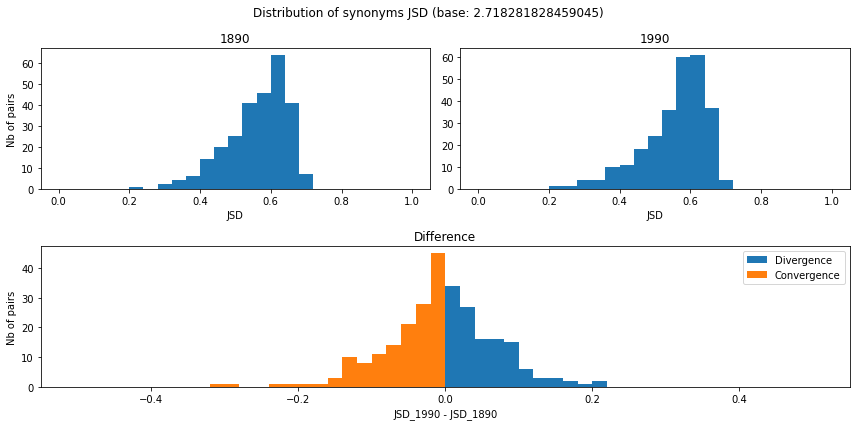

In [116]:
distance_name = f'JSD (base: {base})'
bin_count = 25

fig = plt.figure(figsize=(12,6))
fig.set_facecolor('white')
ax = fig.subplot_mosaic([['1890','1990'],['D','D']])
ax['1890'].hist(distances_1890, bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1890'].set_title('1890')
ax['1990'].hist(distances_1990, bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1990'].set_title('1990')
ax['D'].hist(distances_1990-distances_1890, bins=(np.arange(bin_count+1)*(0.5/bin_count)), label = 'Divergence')
ax['D'].hist(distances_1990-distances_1890, bins=(np.arange(bin_count+1)*(0.5/bin_count)-0.5), label = 'Convergence')
ax['D'].set_title('Difference')
ax['D'].legend()
ax['1890'].set_ylabel('Nb of pairs')
ax['1890'].set_xlabel('JSD')
ax['1990'].set_xlabel('JSD')
ax['D'].set_ylabel('Nb of pairs')
ax['D'].set_xlabel('JSD_1990 - JSD_1890')
fig.suptitle(f'Distribution of synonyms {distance_name}')
fig.tight_layout()
fig.savefig('./img/'+distance_name+'_'+pos+'.png',transparent=False,dpi=100)
plt.show()

In [87]:
rng = np.random.default_rng(0)
n_samples = 50000
samples = rng.choice(len(word_list),size=2*n_samples).reshape( (n_samples,2) )
random_distances_1890 = np.empty(n_samples)
random_distances_1990 = np.empty(n_samples)
for index, (ind1,ind2) in tqdm( enumerate(samples) ):
    v10, v20 = matrix_1890[[ind1,ind2]]
    random_distances_1890[index] = JSD( v10 , v20 , base=base)
    v11, v21 = matrix_1990[[ind1,ind2]]
    random_distances_1990[index] = JSD( v11 , v21 , base=base)

50000it [00:31, 1584.13it/s]


In [88]:
describe(random_distances_1990)

DescribeResult(nobs=50000, minmax=(0.0, 0.9999846670426294), mean=0.939706199001505, variance=0.00427745032280703, skewness=-2.4420150061827277, kurtosis=11.647613561466471)

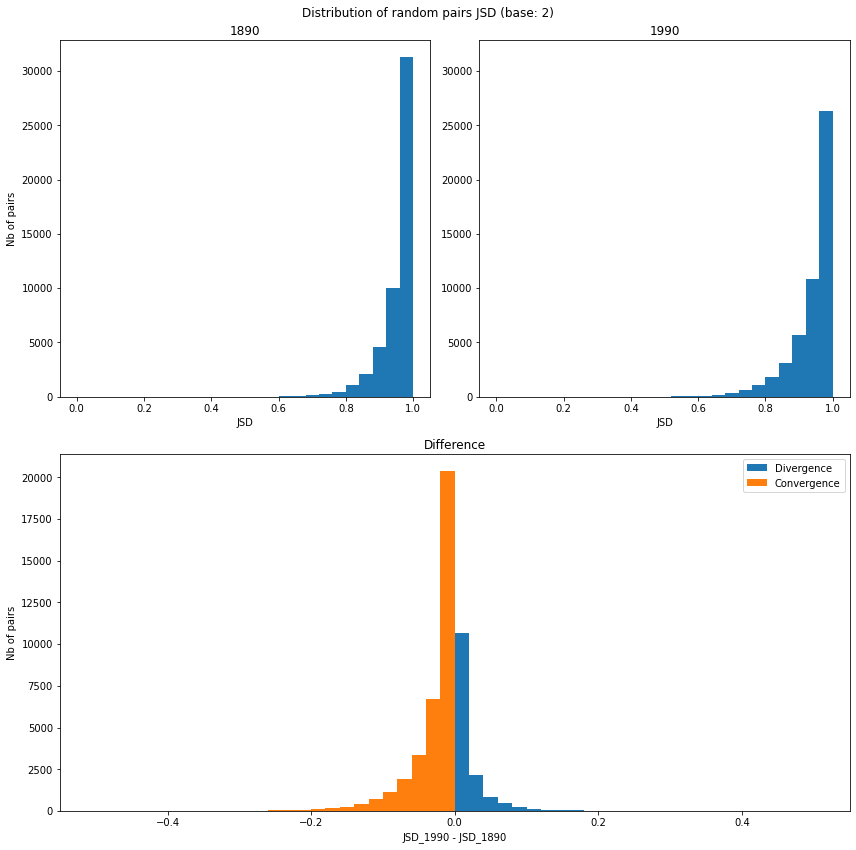

In [90]:
distance_name = f'JSD (base: {base})'
bin_count = 25

fig = plt.figure(figsize=(12,12))
fig.set_facecolor('white')
ax = fig.subplot_mosaic([['1890','1990'],['D','D']])
ax['1890'].hist(random_distances_1890, bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1890'].set_title('1890')
ax['1990'].hist(random_distances_1990, bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1990'].set_title('1990')
ax['1990'].set_ylim( ax['1890'].get_ylim() ) 
diff_random = random_distances_1990-random_distances_1890
ax['D'].hist(diff_random, bins=(np.arange(bin_count+1)*(0.5/bin_count)), label = 'Divergence')
ax['D'].hist(diff_random, bins=(np.arange(bin_count+1)*(0.5/bin_count)-0.5), label = 'Convergence')
ymin, ymax = ax['D'].get_ylim()
ax['D'].vlines(diff_random.mean(),ymin=ymin, ymax=ymax ,label='Average difference',colors='black',linestyles='--',alpha=0.7)
ax['D'].vlines(diff_random.mean()+diff_random.std(), ymin=ymin, ymax=ymax,label='Average difference + 1 std',colors='red',linestyles='--',alpha = 0.7)
ax['D'].set_title('Difference')
ax['D'].legend()
ax['1890'].set_ylabel('Nb of pairs')
ax['1890'].set_xlabel('JSD')
ax['1990'].set_xlabel('JSD')
ax['D'].set_ylabel('Nb of pairs')
ax['D'].set_xlabel('JSD_1990 - JSD_1890')
fig.suptitle(f'Distribution of random pairs {distance_name}')
fig.tight_layout()
fig.savefig('./img/'+distance_name+'_random_'+pos+'.png',transparent=False,dpi=100)
plt.show()

In [117]:
diverge_prop_random = (random_distances_1990-random_distances_1890 > 0).sum()/n_samples
diverge_prop_syns = (distances_1990-distances_1890 > 0).sum()/len(syn_pairs)

print(f'General divergence rate : {diverge_prop_random.round(3)*100}%')
print(f'Synonyms divergence rate : {diverge_prop_syns.round(3)*100}%')

General divergence rate : 29.2%
Synonyms divergence rate : 46.1%


In [92]:
stats.ttest_ind(random_distances_1990-random_distances_1890 , distances_1990 - distances_1890, alternative='two-sided')

Ttest_indResult(statistic=-3.0729307892498103, pvalue=0.002120810176263856)

## Analysing the semantic change of pairs

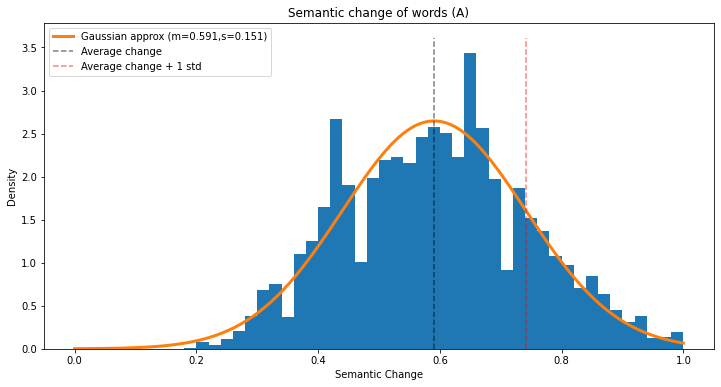

In [93]:
bin_count = 50

sc_series = semchanges['1990']

fig = plt.figure(figsize=(12,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.hist(sc_series, bins=(np.arange(bin_count+1)*(1/bin_count)) ,density=True)
ax.set_title(f'Semantic change of words ({pos})')

mu = sc_series.mean()
sig = sc_series.std()
norm = stats.norm(loc=mu,scale=sig)
x = np.linspace(0,1,200)
ax.plot(x, norm.pdf(x), label = f'Gaussian approx (m={mu.round(3)},s={sig.round(3)})', lw=3)
ymin, ymax = ax.get_ylim()
ax.vlines(mu,ymin=ymin, ymax=ymax ,label='Average change',colors='black',linestyles='--',alpha=0.5)
ax.vlines(mu+sig, ymin=ymin, ymax=ymax,label='Average change + 1 std',colors='red',linestyles='--',alpha = 0.5)


ax.legend(loc='upper left')
ax.set_ylabel('Density')
ax.set_xlabel('Semantic Change')
fig.savefig('./img/SC_'+pos+'.png',transparent=False,dpi=100)
plt.show()

In [94]:
sc_series.median()

0.5900000000000001

## Choosing control pairs

In [103]:
def control_search_naive(s1,s2,base=None, max_trials = 1000, rng=None):
    if type(rng)==int:
        # if using control_search_naive multiple times, please avoid,
        # otherwise the same word will be picked first again and again.
        # prefer passing a generator in rng.
        rng = np.random.default_rng(rng)
    elif type(rng)== np.random._generator.Generator:
        pass
    else:
        rng = np.random.default_rng(None)
    i_s1 = word2ind[s1]
    i_s2 = word2ind[s2]
    v_s1, v_s2 = matrix_1890[[i_s1,i_s2]]
    base_dist = JSD( v_s1 , v_s2 ,base=base)
    base_change = semchanges.loc[s1]['1990'] + semchanges.loc[s2]['1990']
    searching = True
    n_iter = 0
    while n_iter < max_trials:
        i = rng.choice(np.arange(len(word_list)) )
        c1 = word_list[i]
        v_c1 = matrix_1890[i]
        sc_c1 = semchanges.loc[c1]['1990']
        
        for _ in range(20) :
            j = rng.choice(np.arange(len(word_list)) )
            if j != i:
                c2 = word_list[j]
                v_c2 = matrix_1890[j]
                sc_c2 = semchanges.loc[c2]['1990']
                d = JSD(v_c1,v_c2, base = base)
                sc = sc_c1 + sc_c2
                if sc <= base_change and d < base_dist:
                    return (c1,c2,d.round(3),sc.round(3))
                
    raise Exception('Failed to find a control pair. Try increasing <max_trials>.')

In [104]:
control_pairs = list()
rng = np.random.default_rng(0)
for (s1,s2) in tqdm(syn_pairs):
    control_pairs.append( control_search_naive(s1,s2, rng=rng) )

100%|██████████| 271/271 [01:54<00:00,  2.36it/s]


In [105]:
control_pairs[:20]

[('biographical', 'clerical', 0.536, 1.14),
 ('ostentatious', 'fatuous', 0.393, 1.24),
 ('rious', 'similar', 0.47, 0.9),
 ('unwary', 'white', 0.605, 0.67),
 ('subterranean', 'sensuous', 0.522, 1.4),
 ('meagre', 'despicable', 0.453, 1.15),
 ('uninterested', 'irreconcilable', 0.547, 1.08),
 ('imperious', 'ingenious', 0.526, 1.23),
 ('fanciful', 'sordid', 0.518, 1.33),
 ('vertical', 'greenish', 0.612, 0.6),
 ('furthest', 'northward', 0.559, 0.97),
 ('anglican', 'frenchy', 0.603, 0.98),
 ('uncontrollable', 'unregulated', 0.535, 1.15),
 ('unpoetic', 'fragmentary', 0.603, 0.92),
 ('feudal', 'paleolithic', 0.506, 1.31),
 ('embattled', 'mountainous', 0.504, 1.36),
 ('diaphanous', 'satiny', 0.404, 1.0),
 ('impecunious', 'gifted', 0.584, 1.31),
 ('intentional', 'irrelevant', 0.492, 1.23),
 ('dispossessed', 'discarded', 0.411, 0.96)]

## Computing divergence of control pairs

In [111]:
control_distances_1890 = []
control_distances_1990 = []
for i,(c1,c2, _, _) in tqdm(enumerate(control_pairs), desc="Controls", total=len(control_pairs)):
    ind1 = word2ind[c1]
    ind2 = word2ind[c2]
    v10, v20 = matrix_1890[[ind1,ind2]]
    control_distances_1890.append(JSD( v10 , v20 , base=base))
    v11, v21 = matrix_1990[[ind1,ind2]]
    control_distances_1990.append(JSD( v11 , v21 , base=base))
control_distances_1890 = np.array(control_distances_1890)
control_distances_1990 = np.array(control_distances_1990)
describe(control_distances_1890)

Controls: 100%|██████████| 271/271 [00:00<00:00, 1304.73it/s]


DescribeResult(nobs=271, minmax=(0.1745981468441189, 0.676838339674623), mean=0.5271090808919873, variance=0.008795754891675448, skewness=-0.8088186523667502, kurtosis=0.507107114816876)

In [112]:
describe(control_distances_1990)

DescribeResult(nobs=271, minmax=(0.21447921546536325, 0.679609213135781), mean=0.5325503403153407, variance=0.009806801047141623, skewness=-0.7979487524152428, kurtosis=0.10971915462177284)

In [113]:
ld_prop = (distances_1990 > control_distances_1990).sum()/len(distances_1990)
print(f'Law of differentiation: {ld_prop.round(3)*100}% \t Law of parallel change: {(1-ld_prop).round(3)*100}%')

Law of differentiation: 62.4% 	 Law of parallel change: 37.6%


In [114]:
result_binom_test = stats.binomtest( k =  (distances_1990 > control_distances_1990).sum(), n = len(distances_1990), alternative='greater' )
print('Test: \tH0: "LPC/LD are even." \tH1: "LD more frequent than LPC."')
print(f'p-value:\t {result_binom_test.pvalue}\nCI of LD:\t{result_binom_test.proportion_ci()}')

Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 2.810178226709912e-05
CI of LD:	ConfidenceInterval(low=0.5725199574094746, high=1.0)


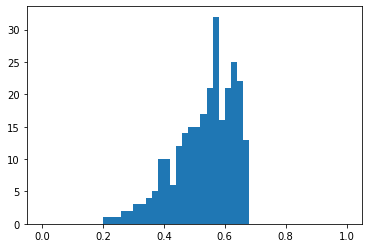

In [40]:
fig = plt.figure()
fig.set_facecolor('white')
bin_count = 50
plt.hist(control_distances_1990, bins=(np.arange(bin_count+1)*(1/bin_count)) )
plt.show()

## To launch many control trials

In [228]:
n_trials = 20
ld_array = np.empty(n_trials)
pvals = np.empty(n_trials)
for seed in range(n_trials):
    control_pairs = list()
    rng = np.random.default_rng(seed)
    for (s1,s2) in tqdm(syn_pairs):
        control_pairs.append( control_search_naive(s1,s2, rng=rng) )

    control_distances_1890 = []
    control_distances_1990 = []
    for i,(c1,c2, _, _) in tqdm(enumerate(control_pairs), desc="Controls", total=len(control_pairs)):
        ind1 = word2ind[c1]
        ind2 = word2ind[c2]
        v10, v20 = matrix_1890[[ind1,ind2]]
        control_distances_1890.append(JSD( v10 , v20 , base=base))
        v11, v21 = matrix_1990[[ind1,ind2]]
        control_distances_1990.append(JSD( v11 , v21 , base=base))
    control_distances_1890 = np.array(control_distances_1890)
    control_distances_1990 = np.array(control_distances_1990)

    ld_prop = (distances_1990 > control_distances_1990).sum()/len(distances_1990)
    print(f'Law of differentiation: {ld_prop.round(3)*100}% \t Law of parallel change: {(1-ld_prop).round(3)*100}%')
    ld_array[seed] = ld_prop
    
    result_binom_test = stats.binomtest( k =  (distances_1990 > control_distances_1990).sum(), n = len(distances_1990), alternative='greater' )
    print('Test: \tH0: "LPC/LD are even." \tH1: "LD more frequent than LPC."')
    print(f'p-value:\t {result_binom_test.pvalue}\nCI of LD:\t{result_binom_test.proportion_ci()}')
    pvals[seed] = result_binom_test.pvalue

Controls: 100%|██████████| 32/32 [00:00<00:00, 1125.37it/s]


Law of differentiation: 78.10000000000001% 	 Law of parallel change: 21.9%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0010512007866054773
CI of LD:	ConfidenceInterval(low=0.6281009405686776, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1226.62it/s]


Law of differentiation: 75.0% 	 Law of parallel change: 25.0%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0035001833457499743
CI of LD:	ConfidenceInterval(low=0.5939430482433805, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1831.02it/s]


Law of differentiation: 81.2% 	 Law of parallel change: 18.8%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0002675263676792383
CI of LD:	ConfidenceInterval(low=0.6631260814910092, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1299.36it/s]


Law of differentiation: 75.0% 	 Law of parallel change: 25.0%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0035001833457499743
CI of LD:	ConfidenceInterval(low=0.5939430482433805, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1281.63it/s]


Law of differentiation: 87.5% 	 Law of parallel change: 12.5%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 9.650597348809242e-06
CI of LD:	ConfidenceInterval(low=0.7364034023902556, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1196.31it/s]


Law of differentiation: 81.2% 	 Law of parallel change: 18.8%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0002675263676792383
CI of LD:	ConfidenceInterval(low=0.6631260814910092, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 928.83it/s]


Law of differentiation: 78.10000000000001% 	 Law of parallel change: 21.9%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0010512007866054773
CI of LD:	ConfidenceInterval(low=0.6281009405686776, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1218.20it/s]


Law of differentiation: 75.0% 	 Law of parallel change: 25.0%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0035001833457499743
CI of LD:	ConfidenceInterval(low=0.5939430482433805, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1079.76it/s]


Law of differentiation: 78.10000000000001% 	 Law of parallel change: 21.9%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0010512007866054773
CI of LD:	ConfidenceInterval(low=0.6281009405686776, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1145.61it/s]


Law of differentiation: 71.89999999999999% 	 Law of parallel change: 28.1%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.010030803503468633
CI of LD:	ConfidenceInterval(low=0.5605533067390448, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1348.68it/s]


Law of differentiation: 68.8% 	 Law of parallel change: 31.2%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.025051229866221547
CI of LD:	ConfidenceInterval(low=0.5278595607023034, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 995.87it/s]


Law of differentiation: 75.0% 	 Law of parallel change: 25.0%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0035001833457499743
CI of LD:	ConfidenceInterval(low=0.5939430482433805, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1012.61it/s]


Law of differentiation: 78.10000000000001% 	 Law of parallel change: 21.9%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0010512007866054773
CI of LD:	ConfidenceInterval(low=0.6281009405686776, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1085.74it/s]


Law of differentiation: 75.0% 	 Law of parallel change: 25.0%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0035001833457499743
CI of LD:	ConfidenceInterval(low=0.5939430482433805, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1113.66it/s]


Law of differentiation: 71.89999999999999% 	 Law of parallel change: 28.1%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.010030803503468633
CI of LD:	ConfidenceInterval(low=0.5605533067390448, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1704.07it/s]


Law of differentiation: 75.0% 	 Law of parallel change: 25.0%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0035001833457499743
CI of LD:	ConfidenceInterval(low=0.5939430482433805, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1106.39it/s]


Law of differentiation: 78.10000000000001% 	 Law of parallel change: 21.9%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0010512007866054773
CI of LD:	ConfidenceInterval(low=0.6281009405686776, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1171.61it/s]


Law of differentiation: 75.0% 	 Law of parallel change: 25.0%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.0035001833457499743
CI of LD:	ConfidenceInterval(low=0.5939430482433805, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1175.82it/s]


Law of differentiation: 62.5% 	 Law of parallel change: 37.5%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.10766357486136258
CI of LD:	ConfidenceInterval(low=0.46436069836162364, high=1.0)


Controls: 100%|██████████| 32/32 [00:00<00:00, 1008.93it/s]

Law of differentiation: 71.89999999999999% 	 Law of parallel change: 28.1%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.010030803503468633
CI of LD:	ConfidenceInterval(low=0.5605533067390448, high=1.0)


In [229]:
ld_prop = ld_array.mean()
pvalue = pvals.mean()
print(f'Law of differentiation: {ld_prop.round(3)*100}% \t Law of parallel change: {(1-ld_prop).round(3)*100}%')
print('Test: \tH0: "LPC/LD are even." \tH1: "LD more frequent than LPC."')
print(f'p-value:\t {pvalue}\n')
    

Law of differentiation: 75.6% 	 Law of parallel change: 24.4%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.009655460296198726



## Junk

In [ ]:
base = None
ind1,ind2 = np.random.choice(np.arange(matrix_1890.shape[0]),size=2)
print( word_list[ind1],word_list[ind2] )
v10, v20 = matrix_1890[[ind1,ind2]]
d_1890 = JSD( v10 , v20 ,base=base)
v11, v21 = matrix_1990[[ind1,ind2]]
d_1990 = JSD( v11 , v21 , base=base)
print(d_1890.round(2),d_1990.round(2))

artful delicious
0.69 0.68


In [10]:
def _JSD(p,q,base=None):
    m = np.mean([p,q],axis=0)
    if base==None or base==np.e:
        log_func = np.log
    elif base == 2:
        log_func = np.log2 
    elif base == 10:
        log_func = np.log10
    return 0.5*( kl_div(p,m,_log=log_func) + kl_div(q,m,_log=log_func))

def kl_div(p,q,_log = np.log):
    sv = 0
    sc = 0
    for i in range( len(p) ):
        if p[i]==0:
            pass
        elif p[i]>0 and q[i]==0:
            sv += p[i]*_log(p[i])
            sc += -np.inf
        elif p[i]>0 and q[i]>0:
            sv += p[i]*_log(p[i])
            sc += p[i]*_log(q[i])
        else:
            return np.nan
    return sv - sc



In [ ]:
def control_search(s1,s2,base=None, max_trials = 1000):
    i_s1 = word2ind[s1]
    i_s2 = word2ind[s2]
    v_s1, v_s2 = matrix_1890[[i_s1,i_s2]]
    base_dist = JSD( v_s1 , v_s2 ,base=base)
    base_change = semchanges.loc[s1]['1990'] + semchanges.loc[s2]['1990']
    searching = True
    n_iter = 0
    while n_iter < max_trials:
        i = np.random.choice(np.arange(len(word_list)) )
        c1 = word_list[i]
        v_c1 = matrix_1890[i]
        neighbors = neighbors_matrix[i]
        sc_c1 = semchanges.loc[c1]['1990']
        
        candidates = []
        
        j = 0
        ind_c2 = neighbors[j]
        c2 = word_list[ind_c2]
        v_c2 = matrix_1890[ind_c2]
        d = JSD( v_c1 , v_c2 ,base=base)
        while d < base_dist:
            if sc_c1 + semchanges.loc[c2]['1990'] <= base_change:
                candidates.append(ind_c2)
            j += 1
            if j >= len(neighbors):
                break
            ind_c2 = neighbors[j]
            c2 = word_list[ind_c2]
            v_c2 = matrix_1890[ind_c2]
            d = JSD( v_c1 , v_c2 ,base=base)
            
        if len(candidates)>0:
            ind_c2 = np.random.choice(candidates)
            c2 = word_list[ind_c2]
            sc_c2 = semchanges.loc[c2]['1990']
            d = JSD( matrix_1890[i] , matrix_1890[ind_c2] ,base=base)
            return ( c1, c2 , d.round(3), (sc_c1+sc_c2).round(3) )
        else:
            n_iter += 1
    raise Exception('Failed to find a control pair. Try increasing <max_trials>.')

In [ ]:
text = ''
for _ in range(10):
    s1,s2 = syn_pairs[np.random.randint(len(syn_pairs))]
    ind1 = word2ind[s1]
    ind2 = word2ind[s2]
    v10, v20 = matrix_1890[[ind1,ind2]]
    d_s = JSD( v10 , v20 )
    sc_s = semchanges.loc[s1]['1990'] + semchanges.loc[s2]['1990']
    text += f'Synonyms : ({s1} , {s2}) \t d={d_s.round(3)}\t SC={sc_s}\nControls: \n'
    for pair in [control_search(s1,s2) for _ in range(10)]:
        c1, c2, d_c, sc_c = pair
        text += f'({c1} , {c2}) \t d={d_c} \t SC={sc_c}\n'
    text += '\n'
with open('controls_sample_heuristic.txt','w',encoding='utf-8') as f:
    f.write(text)

In [ ]:
text = ''
for _ in range(10):
    s1,s2 = syn_pairs[np.random.randint(len(syn_pairs))]
    ind1 = word2ind[s1]
    ind2 = word2ind[s2]
    v10, v20 = matrix_1890[[ind1,ind2]]
    d_s = JSD( v10 , v20 )
    sc_s = semchanges.loc[s1]['1990'] + semchanges.loc[s2]['1990']
    text += f'Synonyms : ({s1} , {s2}) \t d={d_s.round(3)}\t SC={sc_s}\nControls: \n'
    for pair in [control_search_naive(s1,s2) for _ in range(10)]:
        c1, c2, d_c, sc_c = pair
        text += f'({c1} , {c2}) \t d={d_c} \t SC={sc_c}\n'
    text += '\n'
with open('controls_sample_naive.txt','w',encoding='utf-8') as f:
    f.write(text)